## Problem Definition

In the classification framework defined for this case study, the response variable takes a value of 1 in case the given transaction is fraud and 0 otherwise.

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.The task is to get forecast the fraud. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.The features are the result of PCA transformation and aren't intuitive as far as their names are concerned.

The data was downloaded from: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load

In [2]:
# load dataset
dataset = read_csv('./data/creditcard.csv')

In [3]:
set_option('display.width', 100)
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
dataset.shape

(284807, 31)

In [5]:
# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# types
set_option('display.max_rows', 500)
dataset.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [7]:
# describe data
set_option('precision', 3)
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,...,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,284807.000,284807.000
mean,94813.860,3.919e-15,5.683e-16,-8.762e-15,2.811e-15,-1.552e-15,2.040e-15,-1.699e-15,-1.893e-16,-3.148e-15,...,1.473e-16,8.042e-16,5.283e-16,4.456e-15,1.427e-15,1.702e-15,-3.662e-16,-1.218e-16,88.350,0.002
std,47488.146,1.959e+00,1.651e+00,1.516e+00,1.416e+00,1.380e+00,1.332e+00,1.237e+00,1.194e+00,1.099e+00,...,7.345e-01,7.257e-01,6.245e-01,6.056e-01,5.213e-01,4.822e-01,4.036e-01,3.301e-01,250.120,0.042
min,0.000,-5.641e+01,-7.272e+01,-4.833e+01,-5.683e+00,-1.137e+02,-2.616e+01,-4.356e+01,-7.322e+01,-1.343e+01,...,-3.483e+01,-1.093e+01,-4.481e+01,-2.837e+00,-1.030e+01,-2.605e+00,-2.257e+01,-1.543e+01,0.000,0.000
25%,54201.500,-9.204e-01,-5.985e-01,-8.904e-01,-8.486e-01,-6.916e-01,-7.683e-01,-5.541e-01,-2.086e-01,-6.431e-01,...,-2.284e-01,-5.424e-01,-1.618e-01,-3.546e-01,-3.171e-01,-3.270e-01,-7.084e-02,-5.296e-02,5.600,0.000
50%,84692.000,1.811e-02,6.549e-02,1.798e-01,-1.985e-02,-5.434e-02,-2.742e-01,4.010e-02,2.236e-02,-5.143e-02,...,-2.945e-02,6.782e-03,-1.119e-02,4.098e-02,1.659e-02,-5.214e-02,1.342e-03,1.124e-02,22.000,0.000
75%,139320.500,1.316e+00,8.037e-01,1.027e+00,7.433e-01,6.119e-01,3.986e-01,5.704e-01,3.273e-01,5.971e-01,...,1.864e-01,5.286e-01,1.476e-01,4.395e-01,3.507e-01,2.410e-01,9.105e-02,7.828e-02,77.165,0.000
max,172792.000,2.455e+00,2.206e+01,9.383e+00,1.688e+01,3.480e+01,7.330e+01,1.206e+02,2.001e+01,1.559e+01,...,2.720e+01,1.050e+01,2.253e+01,4.585e+00,7.520e+00,3.517e+00,3.161e+01,3.385e+01,25691.160,1.000


In [8]:
dataset['fraud'] = dataset['Class'].map({1:"Fraud", 0:"No Fraud"})

In [9]:
dataset.fraud.value_counts(normalize=True)

No Fraud    0.998
Fraud       0.002
Name: fraud, dtype: float64

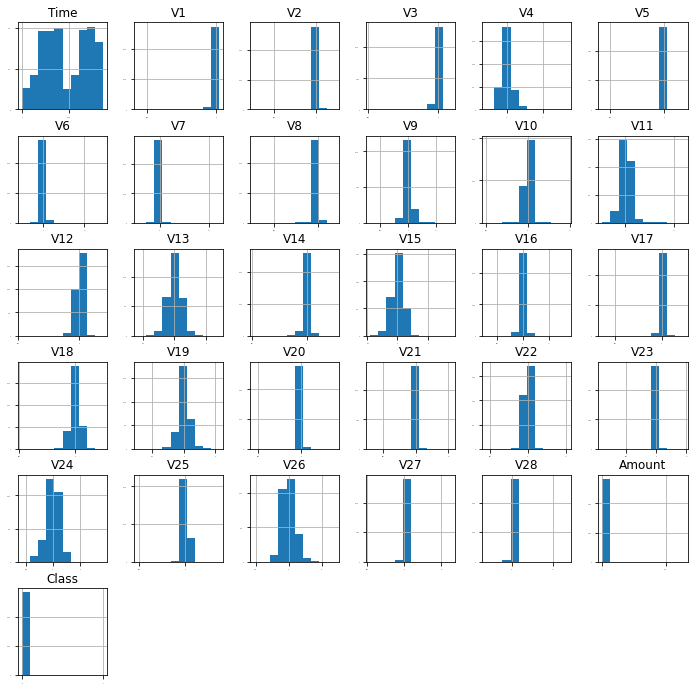

In [10]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

In [11]:
#Checking for any null values and removing the null values'''
dataset.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
fraud     0
dtype: int64

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest( k=10)
bestfeatures
Y= dataset["fraud"]
X = dataset.drop(columns=['Class','fraud'])
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

   Specs      Score
17   V17  33979.169
14   V14  28695.548
12   V12  20749.822
10   V10  14057.980
16   V16  11443.349
3     V3  11014.508
7     V7  10349.605
11   V11   6999.355
4     V4   5163.832
18   V18   3584.381


In [14]:
# split out validation dataset for the end
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
scoring = 'accuracy'

In [15]:
# test options for classification
num_folds = 10
seed = 7

In [16]:
# spot check some basic Classification algorithms
#Given Data is huge, some of the slower classification algorithms are commented
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))
# #Neural Network
# models.append(('NN', MLPClassifier()))
# # #Ensable Models 
# # Boosting methods
# models.append(('AB', AdaBoostClassifier()))
# models.append(('GBM', GradientBoostingClassifier()))
# # Bagging methods
# models.append(('RF', RandomForestClassifier()))
# models.append(('ET', ExtraTreesClassifier()))

In [17]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

In [1]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()

NameError: name 'pyplot' is not defined

In [2]:
# prepare model
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

NameError: name 'DecisionTreeClassifier' is not defined

In [4]:
# estimate accuracy on validation set
#rescaledValidationX = scaler.transform(X_validation)
rescaledValidationX = X_validation
predictions = model.predict(rescaledValidationX)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

NameError: name 'X_validation' is not defined